In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import os
import pathlib
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [2]:
# loading the github dataset
df = pd.read_csv("raw_data/Github_clean2 copy.csv")
file_names = df['Repo_match'].unique()

In [3]:
def datetime_transform(date_string):
    try:
        date_format = "%Y/%m/%d %H:%M:%S"
        # Convert the string to a datetime object
        date_object = datetime.strptime(date_string, date_format)
        return date_object
    except ValueError:
        date_format_1 = "%Y-%m-%d %H:%M:%S"
        date_object = datetime.strptime(date_string, date_format_1)
        return date_object


for file_name in file_names:
    try:
        file_path = f"raw_data/menry copy/{file_name}.csv"
        df_0 = pd.read_csv(file_path,skiprows=1)
        # Leave only the 'username' and 'timestamp' columns
        df_0 = df_0[['username', 'timestamp']]
        if not df_0.empty:
            contributor_list = df_0["username"].unique()
            df.loc[df['Repo_match'] == file_name, "contributor_numbers_in_total"] = len(contributor_list)
            original_contributor = df_0["username"].iloc[-1]
            # Update the 'original_contributor' column in the original DataFrame
            df.loc[df['Repo_match'] == file_name, "original_contributor"] = original_contributor
            df_0["timestamp_datetime"] = df_0["timestamp"].apply(datetime_transform)
            # compute the time intervals and add to df_0
            df_0.sort_values(by='timestamp_datetime', ascending=False, inplace=True)
            df_0['time_interval'] = df_0['timestamp_datetime'].diff(-1)

            # Calculate the number of unique days
            df.loc[df['Repo_match'] == file_name, "no_of_days"] = df_0['timestamp_datetime'].dt.date.nunique()
            df.loc[df['Repo_match'] == file_name, "no_of_commits"] = df_0['timestamp_datetime'].nunique()
            
            # get the number of commits by the original contributor/ or non-original contributors
            df.loc[df['Repo_match'] == file_name, "no_of_commits_original"] = df_0[df_0['username'] == original_contributor]['timestamp_datetime'].nunique()
            df.loc[df['Repo_match'] == file_name, "no_of_commits_non_original"] = df_0[df_0['username'] != original_contributor]['timestamp_datetime'].nunique()
            
            # Filter the dataset to include only commits by the original contributor and calulate average duration
            original_contributor_commits = df_0[df_0['username'] == original_contributor]
            if len(original_contributor_commits["time_interval"]) != 0:
                original_contributor_average_duration = original_contributor_commits['time_interval'].sum()/len(original_contributor_commits["time_interval"])
                df.loc[df['Repo_match'] == file_name, "original_contributor_average_duration"] = original_contributor_average_duration
            else :
                df.loc[df['Repo_match'] == file_name, "original_contributor_average_duration"] = np.nan

            # Filter the dataset to include only commits by the non-original contributor and calulate average duration
            non_original_contributor_commits = df_0[df_0['username'] != original_contributor]
            if len(non_original_contributor_commits) != 0:
                non_original_contributor_average_duration = non_original_contributor_commits['time_interval'].sum()/len(non_original_contributor_commits['time_interval'])
                df.loc[df['Repo_match'] == file_name, "non_original_contributor_average_duration"] = non_original_contributor_average_duration
            else :
                df.loc[df['Repo_match'] == file_name, "non_original_contributor_average_duration"] = np.nan

            # get real time dates
            first_date = df_0['timestamp_datetime'].iloc[-1]
            df.loc[df['Repo_match'] == file_name, "first_day"] = first_date
            first_month_date = timedelta(days=30) + first_date
            six_months_date = timedelta(days=180) + first_date
            one_year_date =  timedelta(days=365) + first_date
            two_years_date = timedelta(days=730) + first_date

            # Count the number of commits made by the original contributor in each time period
            first_month_commits = len(original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= first_month_date) ])
            six_months_commits = len(original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= six_months_date) ])
            one_year_commits = len(original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= one_year_date)])
            two_years_commits = len(original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= two_years_date)])
            df.loc[df['Repo_match'] == file_name, "first_month_commits"] = first_month_commits
            df.loc[df['Repo_match'] == file_name, "six_months_commits"] = six_months_commits
            df.loc[df['Repo_match'] == file_name, "one_year_commits"] = one_year_commits
            df.loc[df['Repo_match'] == file_name, "two_year_commits"] = two_years_commits

            # Group by date, then count the number of commits, then calculate median for origonal contributor
            commits_by_date_original_contributor_1yr = original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= one_year_date)].groupby(original_contributor_commits['timestamp_datetime'].dt.date).size().reset_index(name='commit_count')
            median_commit_count_1yr = commits_by_date_original_contributor_1yr['commit_count'].median()
            df.loc[df['Repo_match'] == file_name, "one_year_median"] = median_commit_count_1yr

            commits_by_date_original_contributor_2yr = original_contributor_commits[(original_contributor_commits['timestamp_datetime'] <= two_years_date)].groupby(original_contributor_commits['timestamp_datetime'].dt.date).size().reset_index(name='commit_count')
            if not commits_by_date_original_contributor_2yr.empty:
                median_commit_count_2yr = commits_by_date_original_contributor_2yr['commit_count'].median()
                df.loc[df['Repo_match'] == file_name, "two_year_median"] = median_commit_count_2yr
            else:
                df.loc[df['Repo_match'] == file_name, "two_year_median"] = 0

            # Group by username, then count the number of commits, then calculate median for not origonal contributor
            commits_by_date_non_original_contributor_1yr = non_original_contributor_commits[(non_original_contributor_commits['timestamp_datetime'] <= one_year_date)].groupby(non_original_contributor_commits["username"]).size().reset_index(name='commit_count')
            if not commits_by_date_non_original_contributor_1yr.empty:
                median_commit_count_1yr_non = commits_by_date_non_original_contributor_1yr['commit_count'].median()
                df.loc[df['Repo_match'] == file_name, "one_year_median_non"] = median_commit_count_1yr_non
            else:
                df.loc[df['Repo_match'] == file_name, "one_year_median_non"] = 0

            commits_by_date_non_original_contributor_2yr = non_original_contributor_commits[(non_original_contributor_commits['timestamp_datetime'] <= two_years_date)].groupby(non_original_contributor_commits["username"]).size().reset_index(name='commit_count')
            if not commits_by_date_non_original_contributor_2yr.empty:
                median_commit_count_2yr_non = commits_by_date_non_original_contributor_2yr['commit_count'].median()
                df.loc[df['Repo_match'] == file_name, "two_year_median_non"] = median_commit_count_2yr_non
            else:
                df.loc[df['Repo_match'] == file_name, "two_year_median_non"] = 0
            
            # reverse df
            reversed_df = df_0[::-1]
            reversed_df["cumulative_original_contributor_commits"] = 0
            reversed_df["cumulative_other_contributor_commits"] = 0

            # Calculate cumulative counts
            original_contributor_mask = reversed_df['username'] == original_contributor
            reversed_df.loc[original_contributor_mask, 'cumulative_original_contributor_commits'] = 1
            reversed_df['cumulative_original_contributor_commits'] = reversed_df['cumulative_original_contributor_commits'].cumsum()
            reversed_df['cumulative_other_contributor_commits'] = (~original_contributor_mask).cumsum()

            # Find the surpassing days
            surpass_df = reversed_df[reversed_df["cumulative_other_contributor_commits"] >= reversed_df["cumulative_original_contributor_commits"]]

            # Check if surpass_df is not empty before assigning values
            if not surpass_df.empty:
                df.loc[df['Repo_match'] == file_name, 'no_of_surpass_days'] = surpass_df['timestamp_datetime'].nunique()
            else:
                df.loc[df['Repo_match'] == file_name, 'no_of_surpass_days'] = 0
        else:
            # Handle the case where the file is empty
            df.loc[df['Repo_match'] == file_name, "original_contributor"] = 1
    except FileNotFoundError:
        # Handle the case where the file is not found
        df.loc[df['Repo_match'] == file_name, "original_contributor"] = 0
        

/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_9655/2680021244.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sahat' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['Repo_match'] == file_name, "original_contributor"] = original_contributor
/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_9655/2680021244.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversed_df["cumulative_original_contributor_commits"] = 0
/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_9655/2680021244.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [4]:
# filter out not applicable values
df = df[(df["original_contributor"] != 0) & (df["original_contributor"] != 1)]

In [5]:
# turn datetime objects into hours
df['non_original_contributor_average_duration'] = df["non_original_contributor_average_duration"].dt.total_seconds() / 3600
df['original_contributor_average_duration'] = df["original_contributor_average_duration"].dt.total_seconds() / 3600

In [6]:
# Turn certain columns to numeric
columns_to_numeric = ["Stars", "Forks", "Pull", "Commit", "Branches", "contributor_numbers_in_total", 
"first_month_commits", "six_months_commits", "one_year_commits", "two_year_commits", "no_of_commits_original",
"one_year_median_non", "two_year_median_non", "original_contributor_average_duration", "non_original_contributor_average_duration",
"no_of_surpass_days","no_of_days"]

# Iterate through columns and convert to numeric
for col in columns_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [ ]:
# List of columns to consider
columns_to_transform = ["Stars", "Forks", "Pull", "Commit", "Branches", "contributor_numbers_in_total", 
"first_month_commits", "six_months_commits", "one_year_commits", "two_year_commits", "no_of_commits_original",
 "one_year_median_non", "two_year_median_non", "original_contributor_average_duration", "non_original_contributor_average_duration",
  "no_of_surpass_days","no_of_days"]
for col in columns_to_transform:
    if df[col].dtype not in (int, float):
        print(f"Skipping {col} as it contains non-numeric data.")
        continue
    
    # Drop NaN values before computing skewness
    skewness = skew(df[col].dropna())

    # Check if skewness is a scalar or a Series
    if isinstance(skewness, np.ndarray):
        skewness = skewness[0]
    print(f"{col}: {skewness}")
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col} with skewness : {skewness}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Save the plot as a PNG file
    plt.savefig(f"figures/{col}_distribution.png")
    if np.abs(skewness) > 0.5:  # Use a threshold like 0.5
        df[f"log_{col}"] = df[col].apply(lambda x: np.log1p(x) if x == 0 else np.log(x))

        scaler = StandardScaler()

        df[f"nom_log_{col}"] = scaler.fit_transform(df[[f"log_{col}"]])
    else:
        df[f"nom_{col}"] = scaler.fit_transform(df[[col]])

In [8]:
# chaeck for possible N.A. values
columns_for_clustering = ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_one_year_median_non", "nom_log_two_year_median_non", "nom_log_original_contributor_average_duration", "nom_log_non_original_contributor_average_duration",
"nom_log_no_of_surpass_days","no_of_days"]


na_values = df[columns_for_clustering].isna().sum()
print(na_values)

nom_log_Stars                                         0
nom_log_Forks                                         0
nom_log_Pull                                          0
nom_log_Commit                                        0
nom_log_Branches                                      0
nom_log_contributor_numbers_in_total                  0
nom_log_first_month_commits                           0
nom_log_six_months_commits                            0
nom_log_one_year_commits                              0
nom_log_two_year_commits                              0
nom_log_no_of_commits_original                        0
nom_log_one_year_median_non                           0
nom_log_two_year_median_non                           0
nom_log_original_contributor_average_duration         0
nom_log_non_original_contributor_average_duration    42
nom_log_no_of_surpass_days                            0
no_of_days                                            0
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

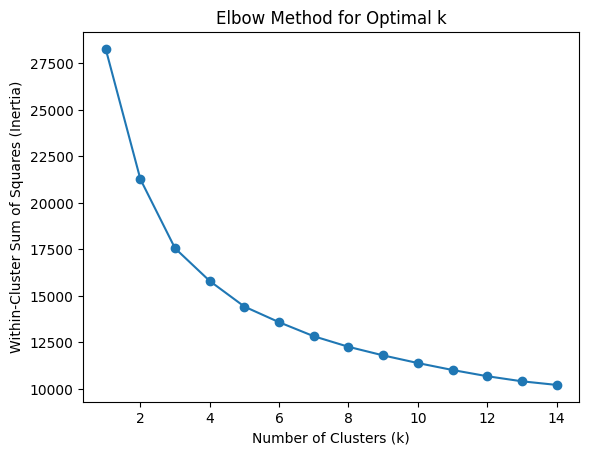

<Figure size 640x480 with 0 Axes>

In [9]:
# Select columns for clustering
columns_for_clustering = ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_original_contributor_average_duration", 
"nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]

#columns not containing na values
#columns_for_clustering = ["nom_log_Stars", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", "nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits","nom_log_original_contributor_average_duration" ]

# Select the subset of DataFrame with chosen columns
df_subset = df[columns_for_clustering]

# Convert values to numeric using a lambda function
df_subset = df_subset.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Drop rows with missing values
df_subset = df_subset.dropna()

# Standardize the features
scaler = StandardScaler()
df_subset = pd.DataFrame(scaler.fit_transform(df_subset), columns=df_subset.columns)



# Find the optimal k using the Elbow Method
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_subset)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 15), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()
 # Save the plot as a PNG file
plt.savefig(f"figures/elbow_method.png")



In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets

columns_for_clustering = ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_original_contributor_average_duration", 
"nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]
# Select the subset of DataFrame with chosen columns
df_subset = df[columns_for_clustering]

# Define a range of values for k
k_values = range(2, 11)  # Start from 2 as silhouette score requires at least two clusters

# Calculate silhouette scores for each value of k
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(df_subset)
    silhouette_scores.append(silhouette_score(df_subset, cluster_labels))

# Find the value of k with the highest silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

print(f"Optimal k determined by silhouette score: {optimal_k}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Optimal k determined by silhouette score: 3


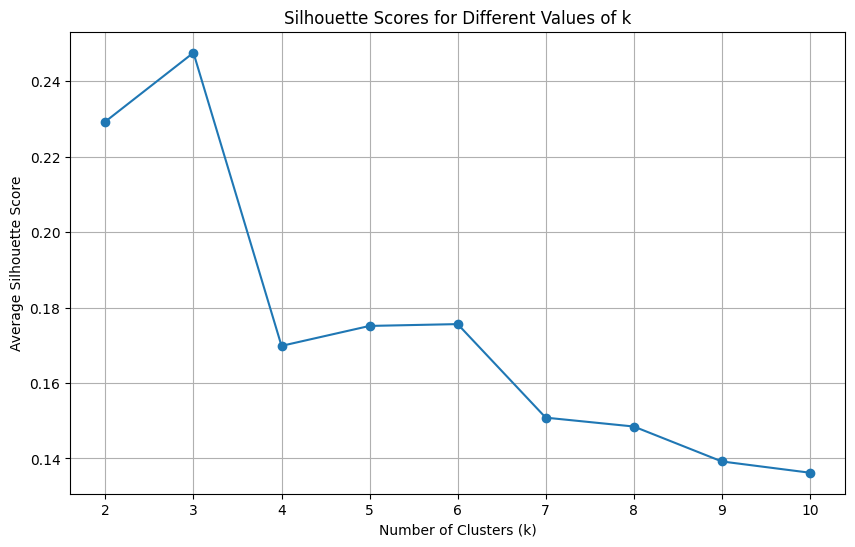

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()
 # Save the plot as a PNG file
plt.savefig(f"figures/silhouette_scores.png")


In [13]:
# the optimal k is 3 (according to silhouette score)
optimal_k = 3

columns_for_clustering = ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_original_contributor_average_duration", 
"nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]
# Select the subset of DataFrame with chosen columns
df_subset = df[columns_for_clustering]

# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_subset['Cluster'] = kmeans.fit_predict(df_subset)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/n2/l02636fd7q11j3gyvhqqs5v80000gn/T/ipykernel_9655/2333667076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Cluster'] = kmeans.fit_predict(df_subset)


In [14]:
# Print clusters

for cluster, group in df_subset.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{group}\n")

Cluster 0:
      nom_log_Stars  nom_log_Forks  nom_log_Pull  nom_log_Commit  \
15         2.336042       2.205406      1.344578       -3.187049   
41         2.424074       2.218092      1.240569       -0.803601   
49         2.502493       0.572691      0.098293       -0.369390   
50         2.100990       1.956444      1.363636        2.016849   
59         2.559076       1.997948      0.969671       -0.257909   
...             ...            ...           ...             ...   
7571      -1.334003      -2.153917     -1.147993       -1.986157   
7591      -1.085599       0.067957     -1.147993        0.263600   
7636      -0.874970      -0.350746     -0.383837       -2.023429   
7644      -1.374307      -1.277315     -1.147993       -1.388973   
7652      -0.260869       0.498102      1.002029        1.122098   

      nom_log_Branches  nom_log_contributor_numbers_in_total  \
15            2.853677                             -1.786989   
41            0.864644                      

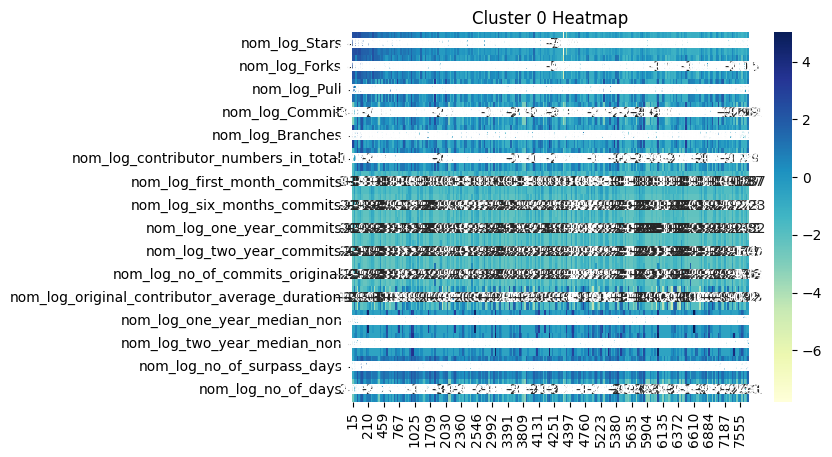

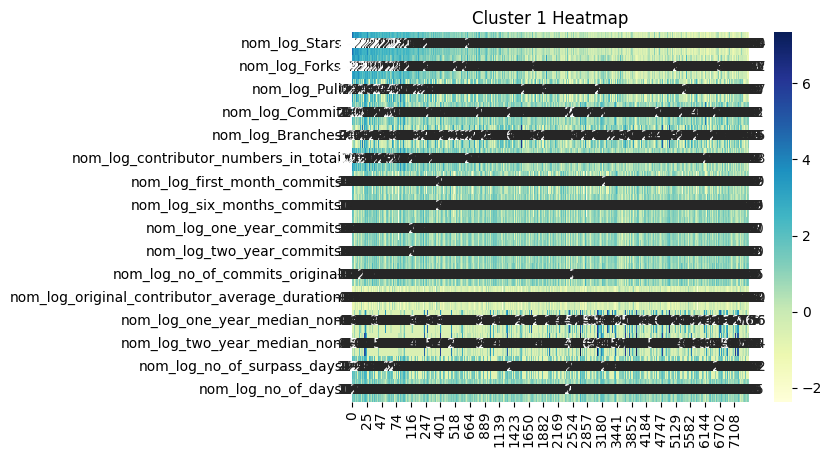

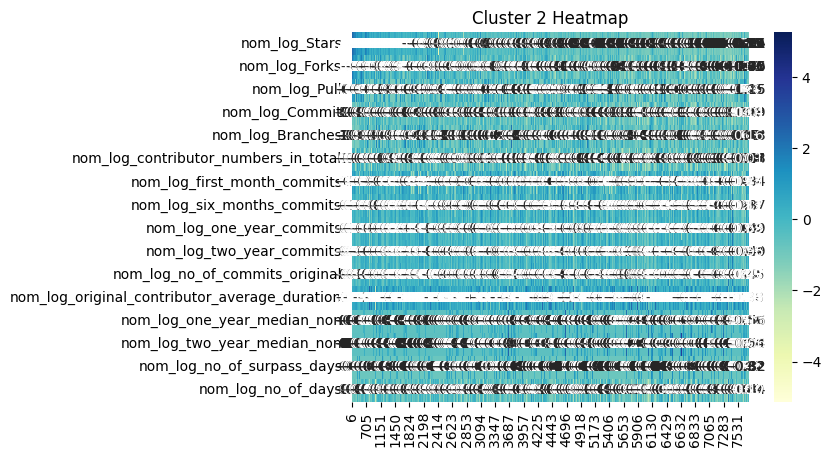

<Figure size 640x480 with 0 Axes>

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# df_subset['Cluster'] = kmeans.fit_predict(df_subset)

# Select relevant columns for the heatmap
heatmap_columns =  ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_original_contributor_average_duration", 
"nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]


# Plot a heatmap for each cluster
for cluster_id in range (0,3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][heatmap_columns]
    cluster_heatmap = sns.heatmap(cluster_data.T, cmap="YlGnBu", annot=True, fmt=".2f")
    cluster_heatmap.set_title(f'Cluster {cluster_id} Heatmap')
    plt.show()
    plt.savefig(f"figures/cluster_{cluster_id}_heatmap0.png")
    


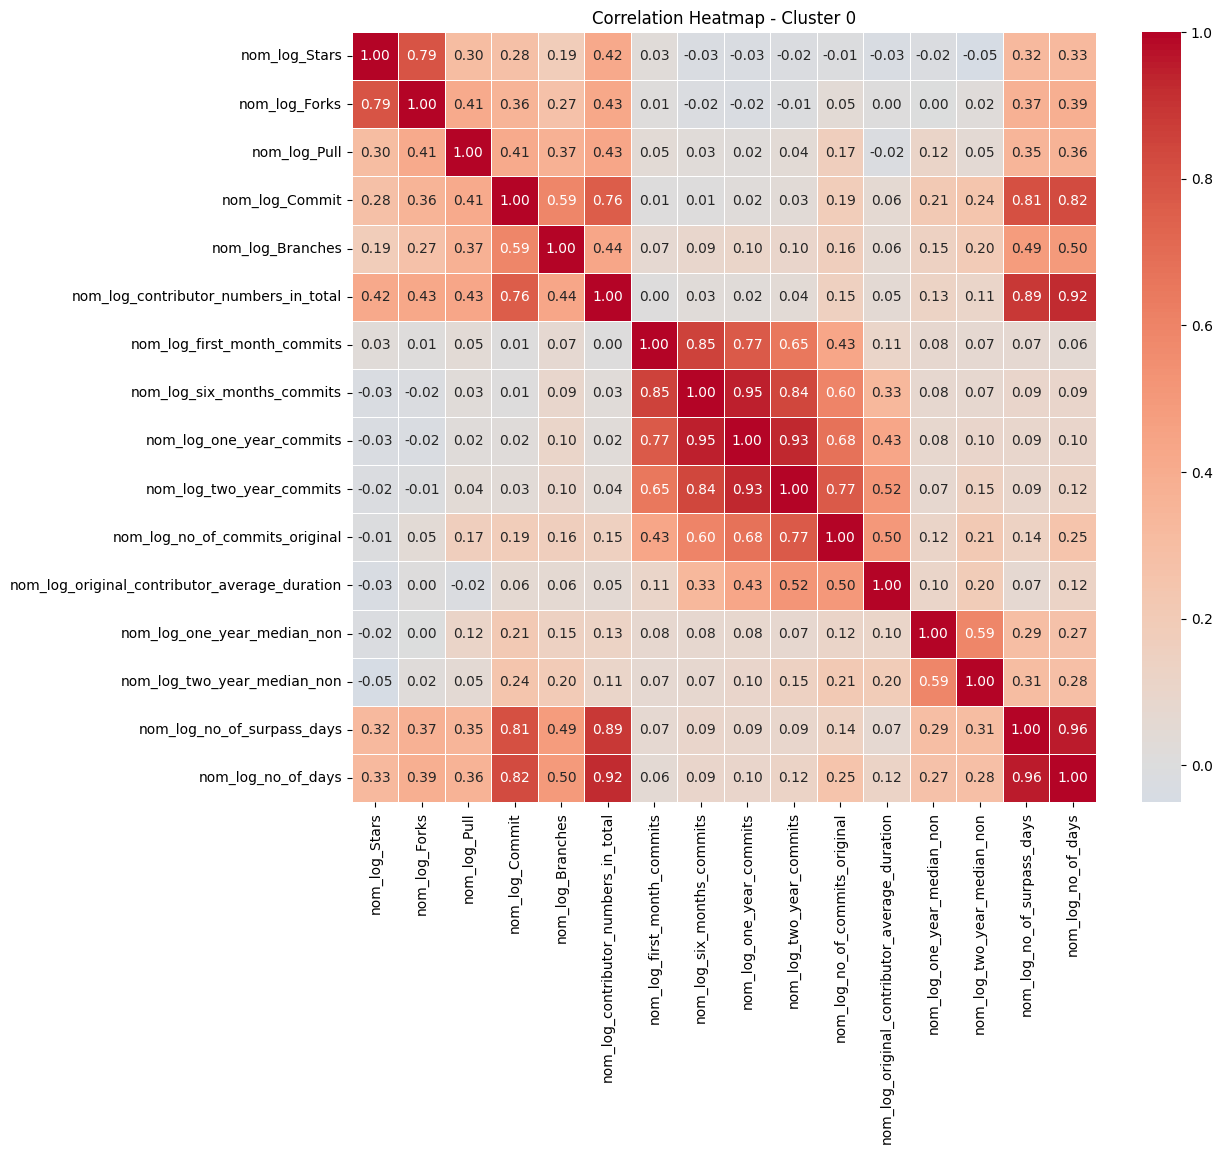

<Figure size 640x480 with 0 Axes>

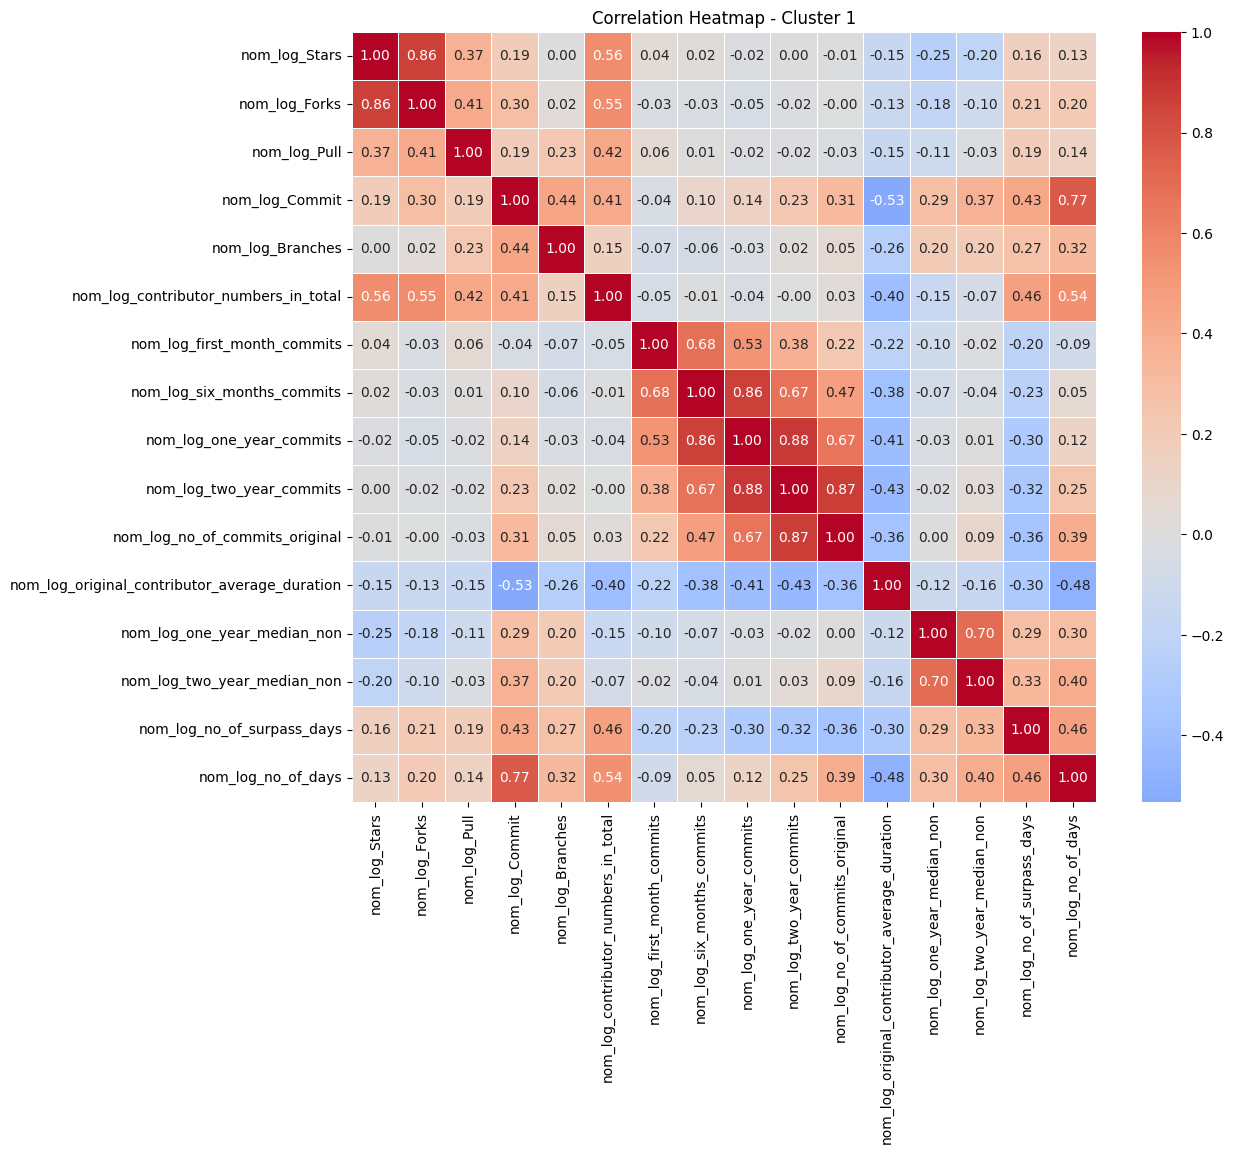

<Figure size 640x480 with 0 Axes>

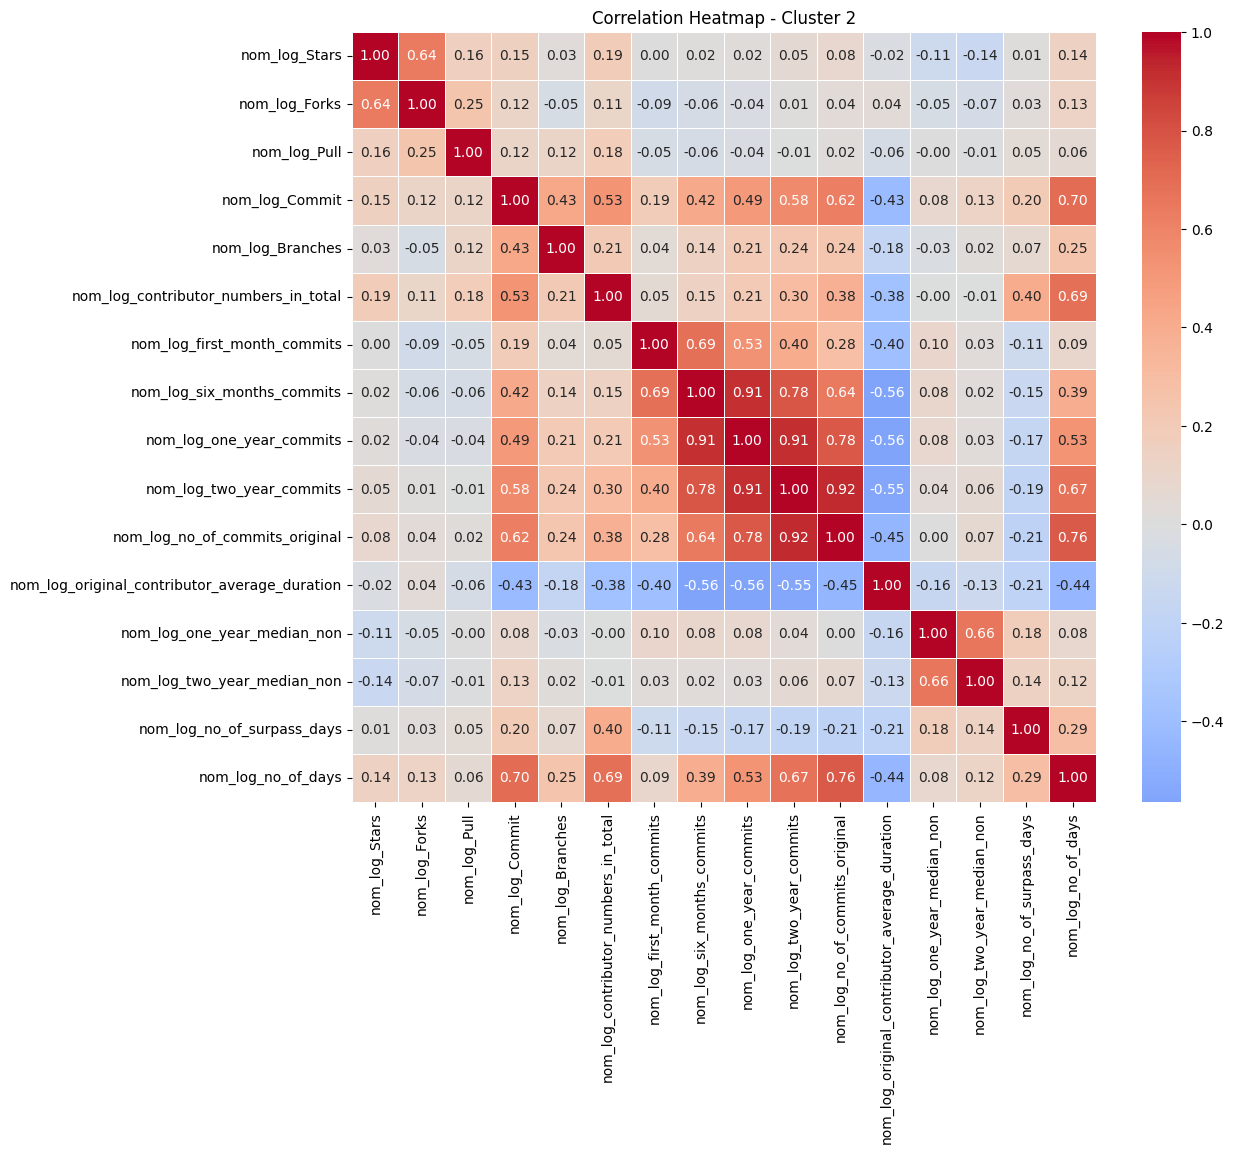

<Figure size 640x480 with 0 Axes>

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_columns =  [
    "nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
    "nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
    "nom_log_original_contributor_average_duration", 
    "nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]

# Plot a separate heatmap for each cluster
for cluster_id in range(0,3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][heatmap_columns]
    cluster_correlation_matrix = cluster_data.corr()
    center_value = 0

    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(cluster_correlation_matrix, center=center_value, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    heatmap.set_title(f'Correlation Heatmap - Cluster {cluster_id}')
    plt.show()
    plt.savefig(f"figures/cluster_{cluster_id}_heatmap_correlation.png")

In [17]:
merged_df = df.merge(df_subset, left_index=True, right_index=True)

columns_to_transform = ["Stars", "Forks", "Pull", "Commit", "Branches", "contributor_numbers_in_total", 
"first_month_commits", "six_months_commits", "one_year_commits", "two_year_commits", "no_of_commits_original",
 "one_year_median_non", "two_year_median_non", "original_contributor_average_duration", "non_original_contributor_average_duration",
  "no_of_surpass_days","no_of_days"]
  
# Group by 'Cluster' and calculate mean and median
cluster_means = merged_df.groupby('Cluster')[columns_to_transform].mean()
cluster_medians = merged_df.groupby('Cluster')[columns_to_transform].median()
cluster_std = merged_df.groupby('Cluster')[columns_to_transform].std()

# Transpose the DataFrames for better visualization
cluster_means_transposed = cluster_means.T
cluster_medians_transposed = cluster_medians.T
cluster_std_transposed = cluster_std.T

cluster_means_transposed.to_csv('tables/cluster_means.csv')
cluster_medians_transposed.to_csv('tables/cluster_medians.csv')
cluster_std_transposed.to_csv('tables/cluster_std.csv')

# Optionally, print the transposed results
print("Mean for each feature in each cluster:")
print(cluster_means_transposed)

print("\nMedian for each feature in each cluster:")
print(cluster_medians_transposed)

print("\nStd for each feature in each cluster:")
print(cluster_std_transposed)

Mean for each feature in each cluster:
Cluster                                              0             1  \
Stars                                      5004.730469  13991.372134   
Forks                                       943.906250   3105.111111   
Pull                                         16.765625     40.132275   
Commit                                     2085.457031   7129.181658   
Branches                                      9.195312     47.996473   
contributor_numbers_in_total                 69.644531    228.402116   
first_month_commits                           2.609375     69.342152   
six_months_commits                            3.480469    264.345679   
one_year_commits                              3.957031    443.865961   
two_year_commits                              4.984375    718.663139   
no_of_commits_original                       27.214844   1394.520282   
one_year_median_non                           5.599609     12.939153   
two_year_median_non      

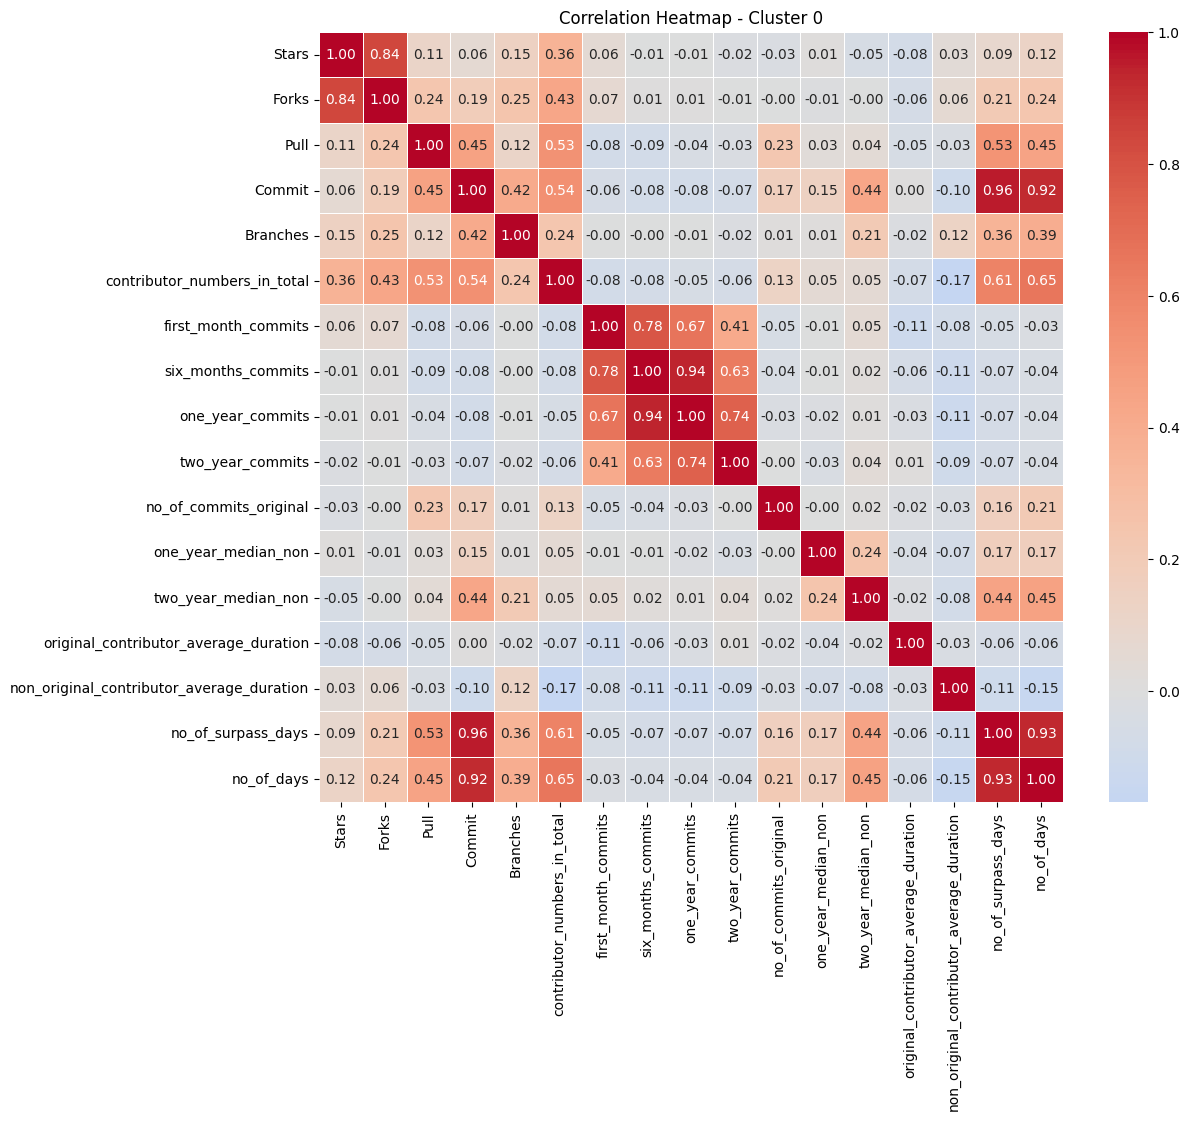

<Figure size 640x480 with 0 Axes>

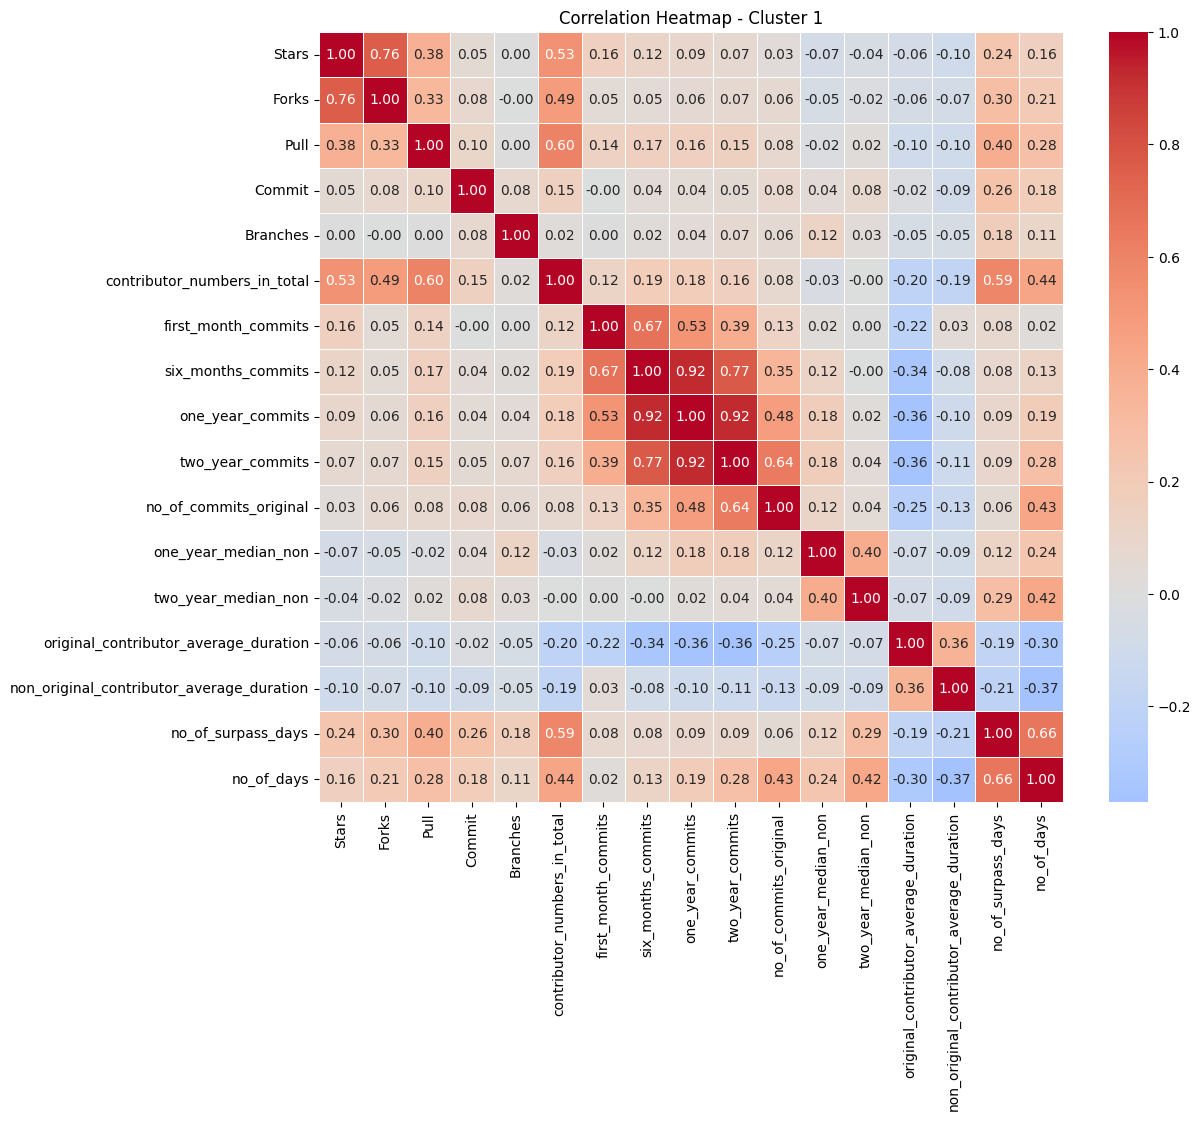

<Figure size 640x480 with 0 Axes>

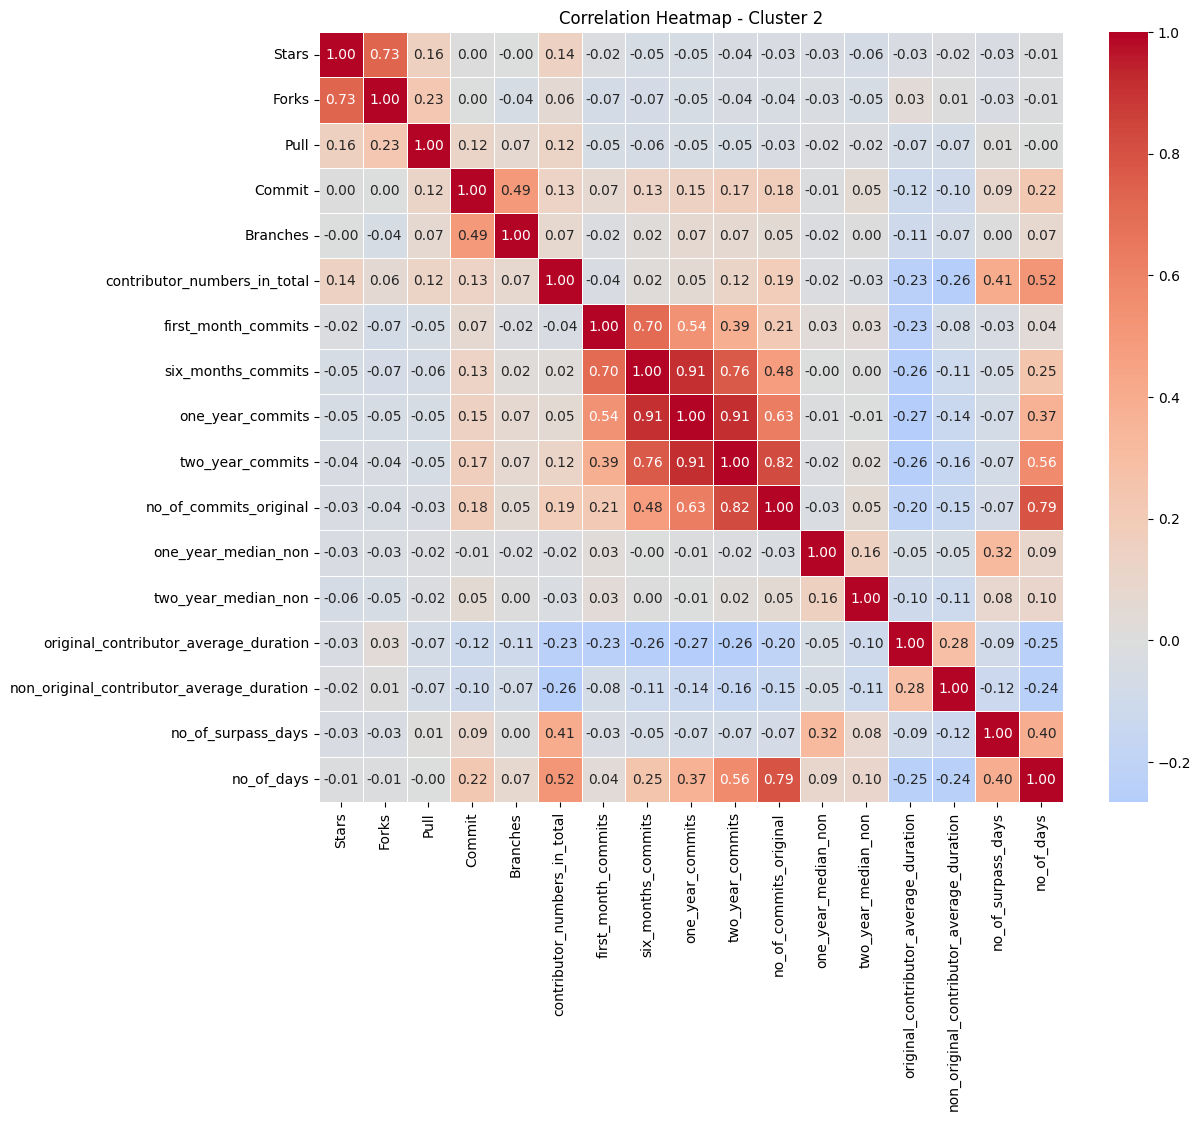

<Figure size 640x480 with 0 Axes>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_columns =  ["Stars", "Forks", "Pull", "Commit", "Branches", "contributor_numbers_in_total", 
"first_month_commits", "six_months_commits", "one_year_commits", "two_year_commits", "no_of_commits_original",
 "one_year_median_non", "two_year_median_non", "original_contributor_average_duration", "non_original_contributor_average_duration",
  "no_of_surpass_days","no_of_days"]

# Plot a separate heatmap for each cluster
for cluster_id in range(0,3):
    cluster_data = merged_df[merged_df['Cluster'] == cluster_id][heatmap_columns]
    cluster_correlation_matrix = cluster_data.corr()
    center_value = 0
    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(cluster_correlation_matrix,  center=center_value, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    heatmap.set_title(f'Correlation Heatmap - Cluster {cluster_id}')
    plt.show()
    plt.savefig(f"figures/cluster_{cluster_id}_heatmap_correlation_2.png")

Linear Regression: 

       nom_log_Stars  nom_log_Forks  nom_log_Pull  nom_log_Commit  \
count     256.000000     256.000000    256.000000      256.000000   
mean       -0.173068      -0.055135      0.002506       -0.181747   
std         0.993642       0.921251      1.003093        1.118782   
min        -7.786620      -5.274873     -1.147993       -3.587346   
25%        -0.773299      -0.648735     -1.147993       -0.748726   
50%        -0.327281      -0.084837     -0.028524       -0.139696   
75%         0.305504       0.494981      0.780523        0.448853   
max         2.559076       2.365786      3.349633        2.826691   

       nom_log_Branches  nom_log_contributor_numbers_in_total  \
count        256.000000                            256.000000   
mean          -0.057417                             -0.111227   
std            0.931762                              1.029582   
min           -1.129982                             -2.252190   
25%           -0.573595                             -

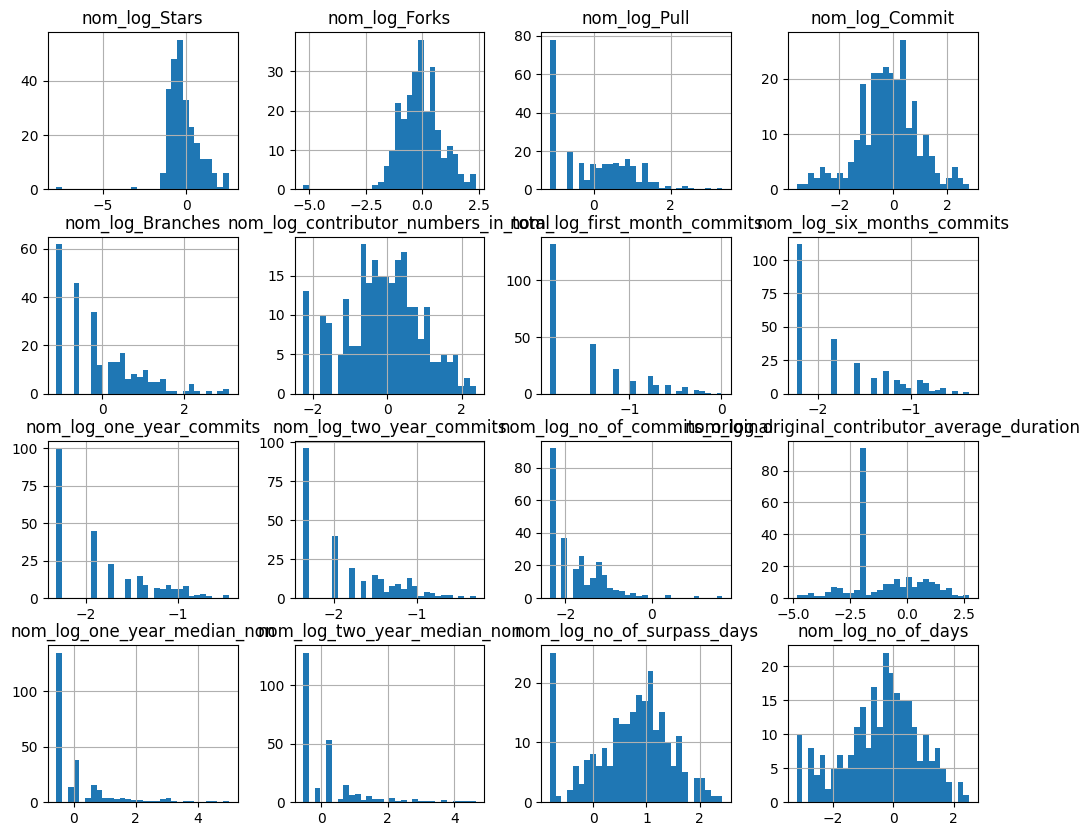

       nom_log_Stars  nom_log_Forks  nom_log_Pull  nom_log_Commit  \
count     567.000000     567.000000    567.000000      567.000000   
mean        0.663620       0.681194      0.569149        0.959402   
std         1.128346       1.042613      1.070412        0.696314   
min        -1.338065      -1.870127     -1.147993       -1.339794   
25%        -0.221561      -0.084847     -0.183735        0.492095   
50%         0.446860       0.546474      0.636097        0.864053   
75%         1.421212       1.278333      1.314902        1.366939   
max         4.561495       4.116524      4.150656        4.267497   

       nom_log_Branches  nom_log_contributor_numbers_in_total  \
count        567.000000                            567.000000   
mean           0.733765                              0.901865   
std            1.072399                              0.740612   
min           -1.129982                             -1.321788   
25%           -0.017208                              

<Figure size 640x480 with 0 Axes>

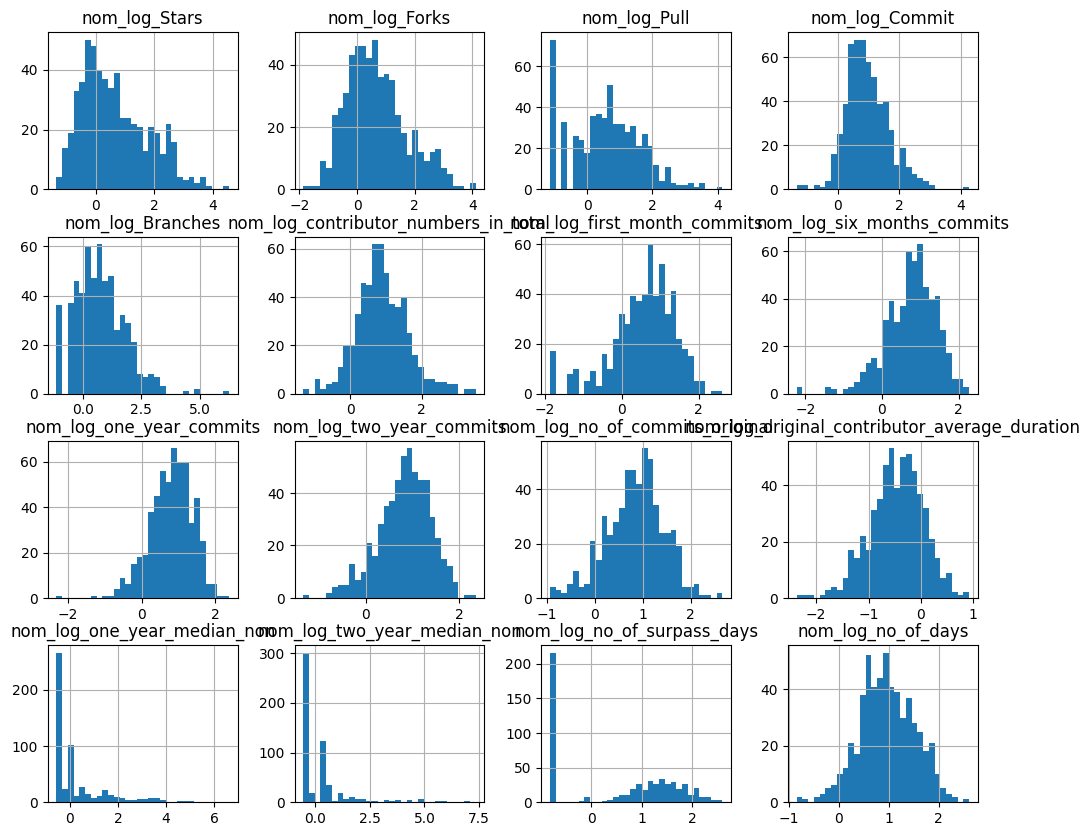

       nom_log_Stars  nom_log_Forks  nom_log_Pull  nom_log_Commit  \
count     944.000000     944.000000    944.000000      944.000000   
mean       -0.351660      -0.394197     -0.342531       -0.526964   
std         0.667780       0.745965      0.775746        0.635554   
min        -5.132314      -3.272629     -1.147993       -2.657885   
25%        -0.820030      -0.885951     -1.147993       -0.939496   
50%        -0.431380      -0.408930     -0.383837       -0.484427   
75%         0.024363       0.057120      0.205514       -0.070882   
max         2.892230       2.435162      1.899993        2.077741   

       nom_log_Branches  nom_log_contributor_numbers_in_total  \
count        944.000000                            944.000000   
mean          -0.425155                             -0.511529   
std            0.665730                              0.709639   
min           -1.129982                             -2.252190   
25%           -1.129982                             -

<Figure size 640x480 with 0 Axes>

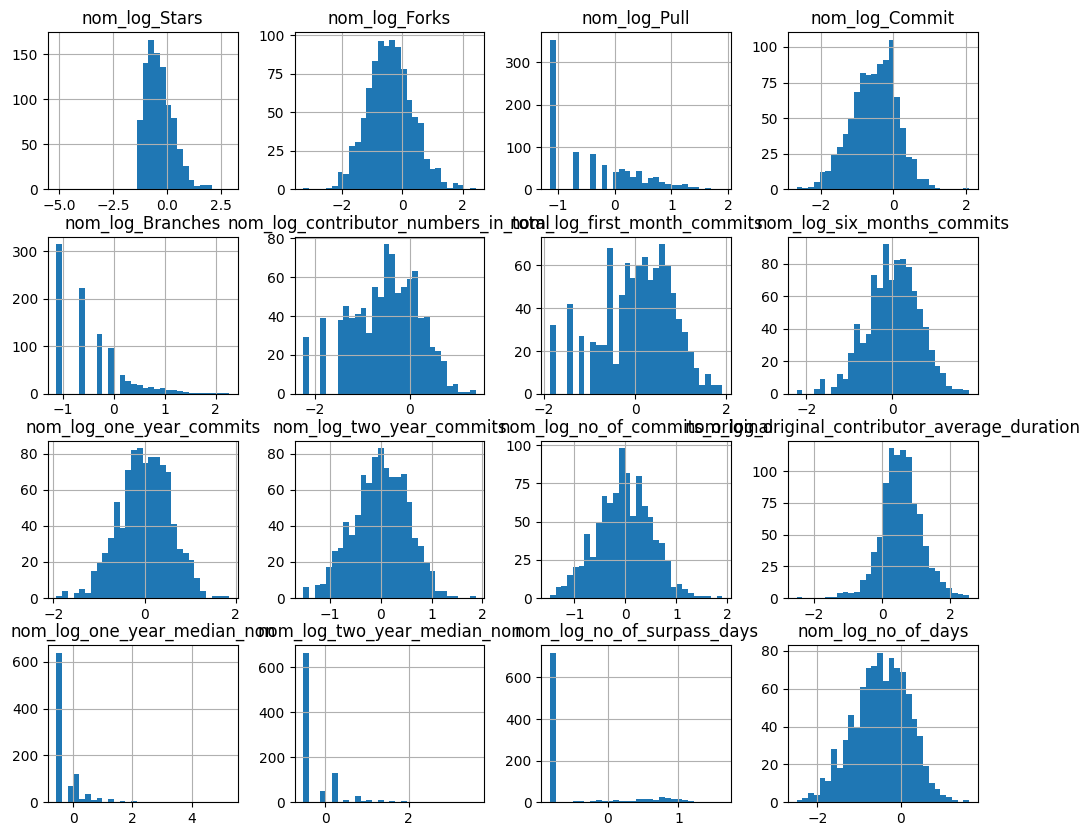

<Figure size 640x480 with 0 Axes>

In [19]:
columns_for_clustering = ["nom_log_Stars", "nom_log_Forks", "nom_log_Pull", "nom_log_Commit", "nom_log_Branches", "nom_log_contributor_numbers_in_total", 
"nom_log_first_month_commits", "nom_log_six_months_commits", "nom_log_one_year_commits", "nom_log_two_year_commits", "nom_log_no_of_commits_original",
"nom_log_original_contributor_average_duration", "nom_log_one_year_median_non", "nom_log_two_year_median_non","nom_log_no_of_surpass_days","nom_log_no_of_days"]

#for each cluster
for cluster_id in range(0,3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][columns_for_clustering]
    print(cluster_data.describe())
    cluster_data.hist(figsize = (12,10), bins = 30)
    plt.show()
    plt.savefig(f"figures/cluster_{cluster_id}_histogram.png")

In [20]:
c0 = ["nom_log_contributor_numbers_in_total", "nom_log_no_of_commits_original"]
c1 = ["nom_log_contributor_numbers_in_total", "nom_log_original_contributor_average_duration", "nom_log_no_of_surpass_days"]
c2 = ["nom_log_contributor_numbers_in_total", "nom_log_one_year_commits"]

In [21]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

for cluster_id in range(3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][columns_for_clustering]
    if cluster_id == 0:
        X = cluster_data[c0]
    elif cluster_id == 1:
        X = cluster_data[c1]
    elif cluster_id == 2:
        X = cluster_data[c2]
    Y = cluster_data["nom_log_Stars"]

    regr = linear_model.LinearRegression()
    regr.fit(X, Y)

    Y_predicted = regr.predict(X)
    print(f'Coefficients for Cluster {cluster_id}: {regr.coef_}')
    est = sm.OLS(Y, X)
    est2 = est.fit()
    print(est2.summary())

Coefficients for Cluster 0: [ 0.41140566 -0.10929264]
                                 OLS Regression Results                                
Dep. Variable:          nom_log_Stars   R-squared (uncentered):                   0.190
Model:                            OLS   Adj. R-squared (uncentered):              0.184
Method:                 Least Squares   F-statistic:                              29.77
Date:                Fri, 24 Nov 2023   Prob (F-statistic):                    2.43e-12
Time:                        10:55:49   Log-Likelihood:                         -338.00
No. Observations:                 256   AIC:                                      680.0
Df Residuals:                     254   BIC:                                      687.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                           coef    std err        

In [22]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


for cluster_id in range(3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][columns_for_clustering]
    if cluster_id == 0:
        X = cluster_data[c0]
    elif cluster_id == 1:
        X = cluster_data[c1]
    elif cluster_id == 2:
        X = cluster_data[c2]
    Y = cluster_data["nom_log_Stars"]

    regr = linear_model.LinearRegression()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=18)
    regr.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = regr.predict(X_test)

    # Evaluate predictions using mean squared error
    mse = mean_squared_error(Y_test, Y_pred)
    print(f'Mean Squared Error for Cluster {cluster_id}: {mse}')

    Y_predicted = regr.predict(X)
    print(f'Coefficients for Cluster {cluster_id}: {regr.coef_}')


Mean Squared Error for Cluster 0: 0.7563278485266942
Coefficients for Cluster 0: [ 0.47673939 -0.10892104]
Mean Squared Error for Cluster 1: 0.819664715872915
Coefficients for Cluster 1: [ 0.94371258  0.18027484 -0.1042221 ]
Mean Squared Error for Cluster 2: 0.48847411529621015
Coefficients for Cluster 2: [ 0.18773891 -0.03207573]


Coefficients for Cluster 0: [[0.40091104]]
Coefficients for Cluster 1: [[0.84915959]]
Coefficients for Cluster 2: [[0.18038351]]


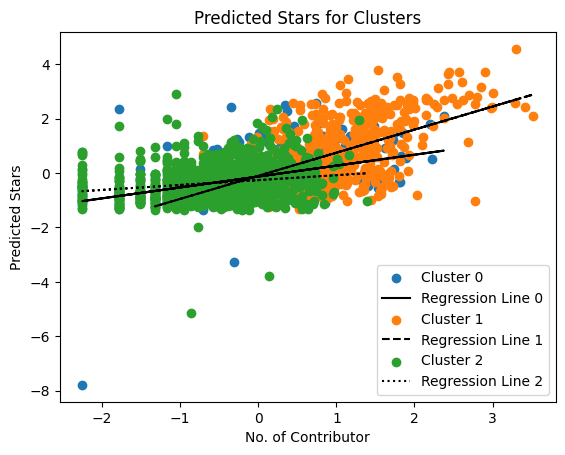

<Figure size 640x480 with 0 Axes>

In [23]:
# Specify line styles for each cluster
line_styles = ['-', '--', ':']

for cluster_id in range(3):
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id][columns_for_clustering]
    X = cluster_data["nom_log_contributor_numbers_in_total"]
    Y = cluster_data["nom_log_Stars"]

    regr = linear_model.LinearRegression()
    regr.fit(X.values.reshape(-1, 1), Y.values.reshape(-1, 1))
    Y_predicted = regr.predict(X.values.reshape(-1, 1))

    print(f'Coefficients for Cluster {cluster_id}: {regr.coef_}')

    # Create a scatter plot for predicted values only
    plt.scatter(X, Y, label=f'Cluster {cluster_id}')
    
    # Keep the regression line color black for all clusters
    plt.plot(X, Y_predicted, linestyle=line_styles[cluster_id], color='black', label=f'Regression Line {cluster_id}')

# Set plot labels and title
plt.title('Predicted Stars for Clusters')
plt.xlabel('No. of Contributor')
plt.ylabel('Predicted Stars')
plt.legend()
plt.show()
plt.savefig(f"figures/predicted_stars_for_clusters.png")